<a href="https://colab.research.google.com/github/shahsalam/tsExtract/blob/master/RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Networks (RNN, LSTM, GRU)

In [ ]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

In [4]:
#!pip install darts

     |████████████████████████████████| 322 kB 10.7 MB/s 
     |████████████████████████████████| 9.8 MB 27.0 MB/s 
     |████████████████████████████████| 65 kB 4.1 MB/s 
     |████████████████████████████████| 791 kB 46.2 MB/s 
     |████████████████████████████████| 177 kB 43.6 MB/s 
     |████████████████████████████████| 1.4 MB 24.8 MB/s 
     |████████████████████████████████| 155 kB 48.1 MB/s 
     |████████████████████████████████| 11.2 MB 45.4 MB/s 
     |████████████████████████████████| 374 kB 46.5 MB/s 
     |████████████████████████████████| 890 kB 49.4 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=92c182b8f9b24b1ae0c53deaf02d108299f1c8b8e372e0e6190f56ec8be698b3
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
  Created wheel for prophet: filename=prophet-1

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel, NBEATSModel
from darts.metrics import mape, mse, rmse, mae, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

## London Energy

In [4]:
# Read a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final11Daily.csv', delimiter=",")
df.reindex(np.arange(len(df)))
df.reset_index(drop=True)

,Time,DateTime,LCLid,KWH
0,1700-01-01,2012-06-01,5,2.870
1,1700-01-02,2012-06-02,5,4.790
2,1700-01-03,2012-06-03,5,5.450
3,1700-01-04,2012-06-04,5,6.700
4,1700-01-05,2012-06-05,5,5.060
...,...,...,...,...
117602,2021-12-27,2012-07-20,877,4.750
117603,2021-12-28,2012-07-21,877,5.397
117604,2021-12-29,2012-07-22,877,8.395
117605,2021-12-30,2012-07-23,877,4.441


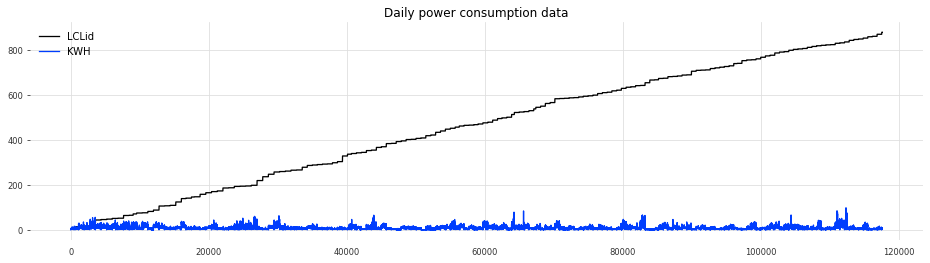

In [5]:
df.plot(figsize=(16,4),legend=True)

plt.title('Daily power consumption data')

plt.show()

In [ ]:
# Check if any duplicates are there
duplicate = df[df.duplicated(['Time'])]
print("Duplicate Rows :")
  
# Print the resultant Dataframe
duplicate


Duplicate Rows :


,Time,DateTime,LCLid,KWH


In [6]:
# Read data:

series1 = TimeSeries.from_dataframe(df,'Time','KWH','LCLid',freq="D")
# Create training and validation sets: 75%
train, val = series1.split_after(pd.Timestamp('19420712'))
#train, val = series1.split_after(pd.Timestamp('21440911'))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series1)

# create month and year covariate series
year_series = datetime_attribute_timeseries(pd.date_range(start=series1.start_time(), freq=series1.freq_str, periods=100000),
                                           attribute='year', one_hot=False)
#year_series = datetime_attribute_timeseries(pd.date_range(start=series1.start_time(), freq=series1.freq_str, periods=100000),
 #                                            attribute='year', one_hot=False)
year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)
day_series = datetime_attribute_timeseries(year_series, attribute='day', one_hot=True)
#covariates = year_series.stack(month_series).stack(day_series)
covariates = year_series.stack(month_series)
#cov_train, cov_val = covariates.split_after(pd.Timestamp('21440911'))
cov_train, cov_val = covariates.split_after(pd.Timestamp('19420712'))


In [7]:
#!pip install matplotlib==3.1.3
series1.head()

<TimeSeries (DataArray) (Time: 5, component: 1, sample: 1)>
array([[[2.87]],

       [[4.79]],

       [[5.45]],

       [[6.7 ]],

       [[5.06]]])
Coordinates:
  * Time       (Time) datetime64[ns] 1700-01-01 1700-01-02 ... 1700-01-05
  * component  (component) object 'KWH'
Dimensions without coordinates: sample

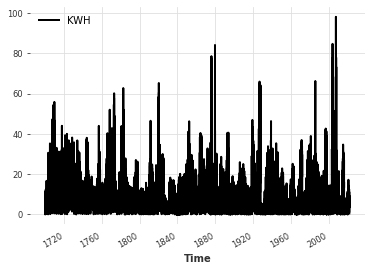

In [8]:
import matplotlib.pyplot as plt
series_energy=series1
series_energy.plot(label='KWH')
plt.legend();

In [9]:
series_transformed.head()

<TimeSeries (DataArray) (Time: 5, component: 1, sample: 1)>
array([[[0.03410576]],

       [[0.05692216]],

       [[0.0647653 ]],

       [[0.07961973]],

       [[0.06013072]]])
Coordinates:
  * Time       (Time) datetime64[ns] 1700-01-01 1700-01-02 ... 1700-01-05
  * component  (component) object 'KWH'
Dimensions without coordinates: sample

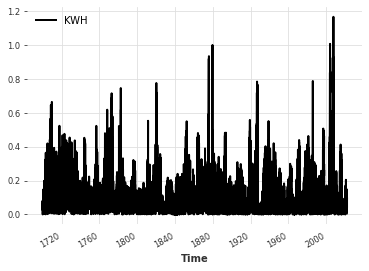

In [10]:
series_energy=series_transformed
series_energy.plot(label='KWH')
plt.legend();

In [11]:
train_transformed.head()

<TimeSeries (DataArray) (Time: 5, component: 1, sample: 1)>
array([[[0.03410576]],

       [[0.05692216]],

       [[0.0647653 ]],

       [[0.07961973]],

       [[0.06013072]]])
Coordinates:
  * Time       (Time) datetime64[ns] 1700-01-01 1700-01-02 ... 1700-01-05
  * component  (component) object 'KWH'
Dimensions without coordinates: sample

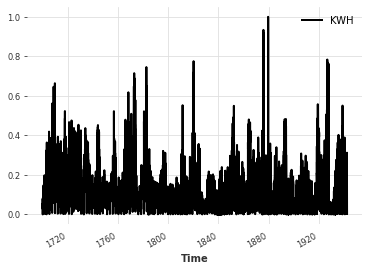

In [12]:
series_energy=train_transformed
series_energy.plot(label='KWH')
plt.legend();

In [13]:
val_transformed.head()

<TimeSeries (DataArray) (Time: 5, component: 1, sample: 1)>
array([[[0.06702317]],

       [[0.11562686]],

       [[0.11431967]],

       [[0.10576352]],

       [[0.07439097]]])
Coordinates:
  * Time       (Time) datetime64[ns] 1942-07-13 1942-07-14 ... 1942-07-17
  * component  (component) object 'KWH'
Dimensions without coordinates: sample

In [14]:
covariates

<TimeSeries (DataArray) (time: 100000, component: 13, sample: 1)>
array([[[0.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [1.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [1.],
        [0.],
        ...,
...
        ...,
        [1.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]]])
Coordinates:
  * time       (time) datetime64[ns] 1700-01-01 1700-01-02 ... 1973-10-16
  * component  (component) object 'year' 'month_1' ... 'month_11' 'month_12'
Dimensions without coordinates: sample

# 1. Generic architecture NBEATS Model

In [16]:
#air_year = datetime_attribute_timeseries(series1, attribute='year')
#air_month = datetime_attribute_timeseries(series1, attribute='month')
#air_day = datetime_attribute_timeseries(series1, attribute='day')

#air_covariates = air_year.stack(air_month)
#air_covariates = air_year.stack(air_month)
#scaler_dt_air = Scaler()
#air_covariates_Scalled = scaler_dt_air.fit_transform(air_covariates)
#air_train_covariates, air_val_covariates = air_covariates[:-364], air_covariates[-364:]

# Read data:
series1 = TimeSeries.from_dataframe(df,'Time','KWH','LCLid',freq="D")
scaler = Scaler()
series1 = scaler.fit_transform(series1)  # scale the whole time series not caring about train/val split...

# We'll use the month as a covariate
month_series = datetime_attribute_timeseries(series1, attribute='month', one_hot=True)
day_series = datetime_attribute_timeseries(series1, attribute='day', one_hot=True)

scaler_Trans = Scaler()
month_series = scaler_Trans.fit_transform(month_series)
day_series = scaler_Trans.fit_transform(day_series)
#covariates = year_series.stack(month_series).stack(day_series)
# Create training and validation sets:
train, val = series1.split_after(pd.Timestamp('19420712'))

# Split Covariate Series
train_month, val_month = month_series.split_after(pd.Timestamp('19420712'))
train_day, val_day = day_series.split_after(pd.Timestamp('19420712'))

In [17]:
val

<TimeSeries (DataArray) (Time: 29027, component: 1, sample: 1)>
array([[[0.05747478]],

       [[0.09915418]],

       [[0.09803322]],

       ...,

       [[0.08554978]],

       [[0.04525629]],

       [[0.04013044]]])
Coordinates:
  * Time       (Time) datetime64[ns] 1942-07-13 1942-07-14 ... 2021-12-31
  * component  (component) object 'KWH'
Dimensions without coordinates: sample

In [ ]:
def eval_model(model):
    pred_series = model_nbeats_Interpretable.predict(n=26, past_covariates=month_series)
    plt.figure(figsize=(15,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();

print("RNN MAPE:", mape(pred_series, val_transformed))
print("RNN RMSE:", rmse(pred_series, val_transformed))
print("RNN MAE:", mae(pred_series, val_transformed))

NameError: ignored

In [49]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(15,5))
    if (start_date):
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.plot(label='Actual')
    pred_series.plot(label=('historic ' + forecast_type + ' forecasts'))
    #plt.title("Energy Consumption")
    plt.title('Comparision of Actual and Predicted Energy Consumption')
    
    

In [20]:
model_nbeats = NBEATSModel(
    input_chunk_length=273,
    output_chunk_length=93,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=8,
    optimizer_kwargs={'lr': 1e-3},
    layer_widths=512,
    n_epochs=5,
    nr_epochs_val_period=1,
    batch_size=800,
    force_reset=True,
    random_state=0,
    save_checkpoints=True,
    model_name='nbeats_run'
  
)

In [21]:
#Training of NBEATS General Model with past covariants
model_nbeats.fit(series=train,
              past_covariates=train_month,
              val_series=val,
              val_past_covariates=val_month,
              verbose=True)

 20%|██        | 1/5 [00:50<03:23, 50.79s/it]

 40%|████      | 2/5 [01:40<02:30, 50.32s/it]

 60%|██████    | 3/5 [02:30<01:40, 50.12s/it]

 80%|████████  | 4/5 [03:20<00:49, 49.94s/it]

100%|██████████| 5/5 [04:09<00:00, 49.96s/it]

In [ ]:
#torch.save(model_nbeats,'/IMV_LSTM-master_Qaboos/darts-master/examples')

In [45]:
#Backtest for the prediction of Energy consumption
pred_G_NBEATS = model_nbeats.historical_forecasts(series=series1,
                                          past_covariates=month_series,
                                          start=pd.Timestamp('20191130'),
                                          forecast_horizon=30,
                                          stride=1,
                                          retrain=False,
                                          verbose=True)

#Inverse Scalling for Ploting
Re_pred_G_NBEATS = scaler.inverse_transform(pred_G_NBEATS)
Re_series1 = scaler.inverse_transform(series1)
#Display the plot of inverse transformed data
display_forecast(Re_pred_G_NBEATS, Re_series1, '7 day', start_date=pd.Timestamp('20191130'))

print("Inverse_NBEATS MAPE:", mape(Re_series1, Re_pred_G_NBEATS))
print("Inverse_NBEATS RMSE:", rmse(Re_series1, Re_pred_G_NBEATS))
print("Inverse_NBEATS MAE:", mae(Re_series1, Re_pred_G_NBEATS))

#Scalled Data Ploting
display_forecast(pred_G_NBEATS, series1, '7 day', start_date=pd.Timestamp('20191130'))
print("NBEATS MAPE:", mape(series1, pred_G_NBEATS))
print("NBEATS RMSE:", rmse(series1, pred_G_NBEATS))
print("NBEATS MAE:", mae(series1, pred_G_NBEATS))

  5%|▍         | 34/734 [00:03<01:02, 11.23it/s]


KeyboardInterrupt: ignored

In [23]:
#Calculations of MAPE, RMSE and MAE
print("Results Without Scalling")
train1, Test_Set = series1.split_after(pd.Timestamp('20191129'))
Re_pred_I_NBEATS = scaler.inverse_transform(pred_G_NBEATS)
Re_series2 = scaler.inverse_transform(Test_Set)
print("Inverse_NBEATS_Interpretable MAPE:", mape(Re_pred_I_NBEATS, Re_series2))
print("Inverse_NBEATS_Interpretable RMSE:", rmse(Re_pred_I_NBEATS, Re_series2))
print("Inverse_NBEATS_Interpretable MAE:", mae(Re_pred_I_NBEATS, Re_series2))

print("Results With Scaling")
print("NBEATS_Interpretable MAPE:", mape(pred_G_NBEATS, Test_Set))
print("NBEATS_Interpretable RMSE:", rmse(pred_G_NBEATS, Test_Set))
print("NBEATS_Interpretable MAE:", mae(pred_G_NBEATS,Test_Set))

Results Without Scalling
Inverse_NBEATS_Interpretable MAPE: 43.81839552950096
Inverse_NBEATS_Interpretable RMSE: 2.9077761261209885
Inverse_NBEATS_Interpretable MAE: 2.2734533203108347
Results With Scaling
NBEATS_Interpretable MAPE: 43.81839552950096
NBEATS_Interpretable RMSE: 0.029631877367991322
NBEATS_Interpretable MAE: 0.023167770511676705


Calculation of RMSE, MAPE and MSE for Generic NBEATS 

# Results Achieved with these settings:

model_nbeats = NBEATSModel(
    input_chunk_length=273,
    output_chunk_length=93,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=8,
    #optimizer_kwargs={'lr': 1e-3},
    layer_widths=512,
    n_epochs=50,
    nr_epochs_val_period=1,
    batch_size=800,
    force_reset=True,
    random_state=0,
    save_checkpoints=True,
    model_name='nbeats_run'
  
)

Inverse_NBEATS MAPE: 33.52346782107026
Inverse_NBEATS RMSE: 2.235457531091175
Inverse_NBEATS MSE: 4.997270373312252

NBEATS MAPE: 34.220390957181884
NBEATS RMSE: 0.04002251463798557
NBEATS MSE: 0.001601801677947769

In [ ]:
best_model = model_nbeats.load_from_checkpoint(model_name='nbeats_run', best=True)
eval_model(best_model)

ValueError: Specified future_covariates for a PastCovariatesModel (only past_covariates are expected).

# 2. Interpretable architecture NBEATS Model

In [76]:
# One user has days of 674 Days (Train 75% 505) (Testing 25% 168)   252     84   
model_nbeats_Interpretable = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=15,
    generic_architecture=False,
    num_blocks=3,
    num_layers=8,
    #optimizer_kwargs={'lr': 1e-2},
    layer_widths=512,
    n_epochs=150,
    nr_epochs_val_period=1,
    batch_size=800,
    #random_state=0,
    force_reset=True,
    save_checkpoints=True,
    model_name='nbeats_interpretable_run'
    
)

In [ ]:
model_nbeats_Interpretable.fit(series=train,
              past_covariates=train_month,
              val_series=val,
              val_past_covariates=val_month,
              verbose=True)

  1%|          | 1/150 [00:37<1:34:11, 37.93s/it]

  1%|▏         | 2/150 [01:17<1:35:56, 38.89s/it]

  2%|▏         | 3/150 [01:55<1:34:00, 38.37s/it]

  3%|▎         | 4/150 [02:32<1:32:33, 38.03s/it]

  3%|▎         | 5/150 [03:10<1:31:39, 37.93s/it]

  4%|▍         | 6/150 [03:48<1:30:59, 37.92s/it]

  5%|▍         | 7/150 [04:26<1:30:13, 37.86s/it]

  5%|▌         | 8/150 [05:04<1:29:46, 37.93s/it]

  6%|▌         | 9/150 [05:41<1:28:58, 37.86s/it]

  7%|▋         | 10/150 [06:20<1:28:30, 37.93s/it]

  7%|▋         | 11/150 [06:57<1:27:54, 37.94s/it]

  8%|▊         | 12/150 [07:35<1:27:14, 37.93s/it]

  9%|▊         | 13/150 [08:13<1:26:31, 37.89s/it]

  9%|▉         | 14/150 [08:51<1:25:48, 37.85s/it]

 10%|█         | 15/150 [09:29<1:25:06, 37.83s/it]

 11%|█         | 16/150 [10:07<1:24:30, 37.84s/it]

 11%|█▏        | 17/150 [10:44<1:23:45, 37.79s/it]

 12%|█▏        | 18/150 [11:22<1:23:13, 37.83s/it]

 13%|█▎        | 19/150 [12:00<1:22:36, 37.83s/it]

 13%|█▎        | 20/150 [12:38<1:21:48, 37.76s/it]

 14%|█▍        | 21/150 [13:16<1:21:25, 37.87s/it]

 15%|█▍        | 22/150 [13:54<1:20:50, 37.89s/it]

 15%|█▌        | 23/150 [14:32<1:20:15, 37.92s/it]

 16%|█▌        | 24/150 [15:09<1:19:23, 37.81s/it]

 17%|█▋        | 25/150 [15:47<1:18:44, 37.79s/it]

 17%|█▋        | 26/150 [16:24<1:17:53, 37.69s/it]

 18%|█▊        | 27/150 [17:02<1:17:14, 37.68s/it]

 19%|█▊        | 28/150 [17:40<1:16:41, 37.72s/it]

 19%|█▉        | 29/150 [18:18<1:16:00, 37.69s/it]

 20%|██        | 30/150 [18:55<1:15:22, 37.69s/it]

 21%|██        | 31/150 [19:33<1:14:48, 37.72s/it]

 21%|██▏       | 32/150 [20:10<1:14:03, 37.65s/it]

 22%|██▏       | 33/150 [20:48<1:13:25, 37.65s/it]

 23%|██▎       | 34/150 [21:26<1:12:42, 37.61s/it]

 23%|██▎       | 35/150 [22:03<1:12:06, 37.62s/it]

 24%|██▍       | 36/150 [22:41<1:11:26, 37.60s/it]

 25%|██▍       | 37/150 [23:18<1:10:47, 37.59s/it]

 25%|██▌       | 38/150 [23:56<1:10:04, 37.54s/it]

 26%|██▌       | 39/150 [24:33<1:09:27, 37.55s/it]

 27%|██▋       | 40/150 [25:11<1:08:53, 37.58s/it]

 27%|██▋       | 41/150 [25:48<1:08:07, 37.50s/it]

 28%|██▊       | 42/150 [26:26<1:07:19, 37.40s/it]

 29%|██▊       | 43/150 [27:03<1:06:43, 37.42s/it]

 29%|██▉       | 44/150 [27:41<1:06:10, 37.45s/it]

 30%|███       | 45/150 [28:18<1:05:33, 37.46s/it]

 31%|███       | 46/150 [28:55<1:04:53, 37.43s/it]

 31%|███▏      | 47/150 [29:33<1:04:22, 37.50s/it]

 32%|███▏      | 48/150 [30:11<1:03:57, 37.62s/it]

 33%|███▎      | 49/150 [30:49<1:03:31, 37.74s/it]

 33%|███▎      | 50/150 [31:27<1:02:48, 37.69s/it]

 34%|███▍      | 51/150 [32:04<1:02:13, 37.72s/it]

 35%|███▍      | 52/150 [32:42<1:01:27, 37.63s/it]

 35%|███▌      | 53/150 [33:19<1:00:50, 37.63s/it]

 36%|███▌      | 54/150 [33:57<1:00:11, 37.62s/it]

 37%|███▋      | 55/150 [34:35<59:32, 37.60s/it]  

 37%|███▋      | 56/150 [35:12<58:57, 37.63s/it]

 38%|███▊      | 57/150 [35:50<58:20, 37.64s/it]

 39%|███▊      | 58/150 [36:28<57:46, 37.68s/it]

 39%|███▉      | 59/150 [37:06<57:14, 37.74s/it]

 40%|████      | 60/150 [37:43<56:37, 37.75s/it]

 41%|████      | 61/150 [38:21<56:04, 37.80s/it]

 41%|████▏     | 62/150 [38:59<55:33, 37.88s/it]

 42%|████▏     | 63/150 [39:37<54:47, 37.78s/it]

 43%|████▎     | 64/150 [40:15<54:10, 37.79s/it]

 43%|████▎     | 65/150 [40:53<53:33, 37.81s/it]

 44%|████▍     | 66/150 [41:30<52:49, 37.73s/it]

 45%|████▍     | 67/150 [42:08<52:13, 37.75s/it]

 45%|████▌     | 68/150 [42:45<51:30, 37.69s/it]

 46%|████▌     | 69/150 [43:23<50:55, 37.72s/it]

 47%|████▋     | 70/150 [44:01<50:11, 37.65s/it]

 47%|████▋     | 71/150 [44:38<49:29, 37.59s/it]

 48%|████▊     | 72/150 [45:16<48:52, 37.60s/it]

 49%|████▊     | 73/150 [45:53<48:16, 37.61s/it]

 49%|████▉     | 74/150 [46:31<47:36, 37.59s/it]

 50%|█████     | 75/150 [47:09<47:02, 37.64s/it]

 51%|█████     | 76/150 [47:46<46:28, 37.68s/it]

 51%|█████▏    | 77/150 [48:24<45:46, 37.62s/it]

 52%|█████▏    | 78/150 [49:02<45:08, 37.62s/it]

 53%|█████▎    | 79/150 [49:39<44:24, 37.53s/it]

 53%|█████▎    | 80/150 [50:16<43:45, 37.51s/it]

 54%|█████▍    | 81/150 [50:54<43:08, 37.51s/it]

 55%|█████▍    | 82/150 [51:34<43:15, 38.17s/it]

 55%|█████▌    | 83/150 [52:11<42:21, 37.93s/it]

 56%|█████▌    | 84/150 [52:48<41:34, 37.80s/it]

 57%|█████▋    | 85/150 [53:26<40:50, 37.70s/it]

 57%|█████▋    | 86/150 [54:03<40:05, 37.59s/it]

 58%|█████▊    | 87/150 [54:41<39:25, 37.55s/it]

 59%|█████▊    | 88/150 [55:18<38:47, 37.53s/it]

 59%|█████▉    | 89/150 [55:56<38:11, 37.56s/it]

 60%|██████    | 90/150 [56:33<37:32, 37.55s/it]

 61%|██████    | 91/150 [57:11<36:58, 37.61s/it]

 61%|██████▏   | 92/150 [57:49<36:26, 37.70s/it]

 62%|██████▏   | 93/150 [58:27<35:50, 37.72s/it]

 63%|██████▎   | 94/150 [59:05<35:14, 37.76s/it]

 63%|██████▎   | 95/150 [59:42<34:38, 37.80s/it]

 64%|██████▍   | 96/150 [1:00:21<34:04, 37.86s/it]

 65%|██████▍   | 97/150 [1:00:58<33:25, 37.84s/it]

 65%|██████▌   | 98/150 [1:01:36<32:44, 37.78s/it]

 66%|██████▌   | 99/150 [1:02:14<32:05, 37.76s/it]

 67%|██████▋   | 100/150 [1:02:51<31:26, 37.74s/it]

 67%|██████▋   | 101/150 [1:03:29<30:47, 37.71s/it]

 68%|██████▊   | 102/150 [1:04:06<30:06, 37.63s/it]

 69%|██████▊   | 103/150 [1:04:44<29:31, 37.69s/it]

 69%|██████▉   | 104/150 [1:05:22<28:54, 37.70s/it]

 70%|███████   | 105/150 [1:06:00<28:13, 37.64s/it]

 71%|███████   | 106/150 [1:06:38<27:42, 37.78s/it]

 71%|███████▏  | 107/150 [1:07:16<27:09, 37.89s/it]

 72%|███████▏  | 108/150 [1:07:54<26:41, 38.14s/it]

 73%|███████▎  | 109/150 [1:08:33<26:11, 38.33s/it]

 73%|███████▎  | 110/150 [1:09:12<25:40, 38.51s/it]

 74%|███████▍  | 111/150 [1:09:51<25:05, 38.60s/it]

 75%|███████▍  | 112/150 [1:10:29<24:21, 38.46s/it]

 75%|███████▌  | 113/150 [1:11:07<23:36, 38.28s/it]

 76%|███████▌  | 114/150 [1:11:44<22:48, 38.01s/it]

 77%|███████▋  | 115/150 [1:12:23<22:16, 38.20s/it]

 77%|███████▋  | 116/150 [1:13:02<21:47, 38.44s/it]

 78%|███████▊  | 117/150 [1:13:41<21:10, 38.51s/it]

 79%|███████▊  | 118/150 [1:14:19<20:30, 38.46s/it]

 79%|███████▉  | 119/150 [1:15:00<20:17, 39.28s/it]

 80%|████████  | 120/150 [1:15:38<19:23, 38.79s/it]

 81%|████████  | 121/150 [1:16:15<18:33, 38.40s/it]

 81%|████████▏ | 122/150 [1:16:53<17:48, 38.16s/it]

 82%|████████▏ | 123/150 [1:17:33<17:23, 38.66s/it]

 83%|████████▎ | 124/150 [1:18:13<16:56, 39.08s/it]

 83%|████████▎ | 125/150 [1:18:51<16:12, 38.92s/it]

 84%|████████▍ | 126/150 [1:19:30<15:32, 38.87s/it]

 85%|████████▍ | 127/150 [1:20:08<14:49, 38.68s/it]

100%|██████████| 763/763 [00:47<00:00, 16.12it/s]


MSE: 5.17
RMSE: 2.27
MAE: 1.73


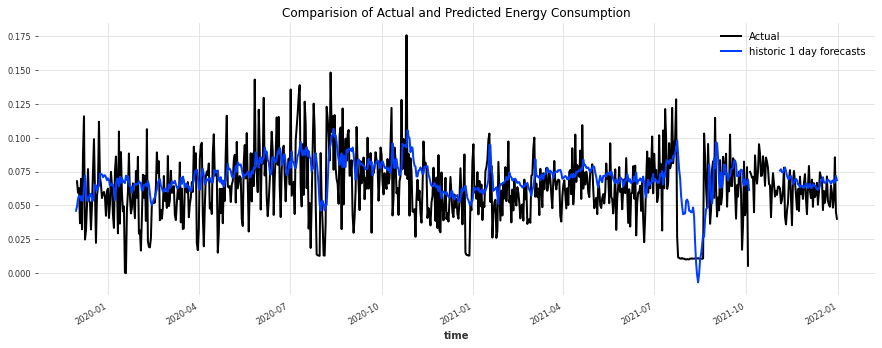

In [75]:
pred_series_Inter_NBEATS = model_nbeats_Interpretable.historical_forecasts(
    series1,
    start=pd.Timestamp('20191130'), 
    past_covariates=month_series,
    forecast_horizon=1,
    stride=1,
    retrain=False,
    verbose=True
)
display_forecast(pred_series_Inter_NBEATS, series1, '1 day', start_date=pd.Timestamp('20191130'))

print('MSE: {:.2f}'.format(mse(transformer.inverse_transform(val_transformed), 
                                 transformer.inverse_transform(pred_series_Inter_NBEATS))))
print('RMSE: {:.2f}'.format(rmse(transformer.inverse_transform(val_transformed), 
                                  transformer.inverse_transform(pred_series_Inter_NBEATS))))
print('MAE: {:.2f}'.format(mae(transformer.inverse_transform(val_transformed), 
                                  transformer.inverse_transform(pred_series_Inter_NBEATS))))

In [68]:
#Calculations of MAPE, RMSE and MAE
print("Results Without Scalling")
train1, Test_Set = series1.split_after(pd.Timestamp('20191130'))
Re_pred_I_NBEATS = scaler.inverse_transform(pred_series_Inter_NBEATS)
Re_series2 = scaler.inverse_transform(Test_Set)
print("Inverse_NBEATS_Interpretable MAPE:", mape(Re_pred_I_NBEATS, Re_series2))
print("Inverse_NBEATS_Interpretable RMSE:", rmse(Re_pred_I_NBEATS, Re_series2))
print("Inverse_NBEATS_Interpretable MAE:", mae(Re_pred_I_NBEATS, Re_series2))


Results Without Scalling
Inverse_NBEATS_Interpretable MAPE: 29.98685294274741
Inverse_NBEATS_Interpretable RMSE: 2.7916301043964658
Inverse_NBEATS_Interpretable MAE: 2.174493902367974


In [ ]:
best_model_Inter = model_nbeats_Interpretable.load_from_checkpoint(model_name='nbeats_interpretable_run', best=True)
eval_model(best_model_Inter)

# Results
model_nbeats_Interpretable = NBEATSModel(
    input_chunk_length=273,
    output_chunk_length=93,
    generic_architecture=False,
    num_blocks=3,
    num_layers=8,
    optimizer_kwargs={'lr': 1e-3},
    layer_widths=512,
    n_epochs=50,
    nr_epochs_val_period=1,
    batch_size=800,
    random_state=0,
    force_reset=True,
    save_checkpoints=True,
    model_name='nbeats_interpretable_run'
    
)
Inverse_NBEATS_Interpretable MAPE: 29.51236031180021
Inverse_NBEATS_Interpretable RMSE: 2.202253609934852
Inverse_NBEATS_Interpretable MSE: 4.849920962471088
NBEATS_Interpretable MAPE: 29.905275018982135
NBEATS_Interpretable RMSE: 0.03942804822471903
NBEATS_Interpretable MSE: 0.0015545709868107693


# 3. Deep Learning Model  RNN

Let's train an LSTM neural net. For using vanilla RNN or GRU instead, replace `'LSTM'` by `'RNN'` or `'GRU'`, respectively.

In [ ]:
RNN_model = RNNModel(
    model='RNN',
    hidden_dim=20,
    dropout=0,
    batch_size=300,
    n_epochs=50,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='Air_RNN',
    log_tensorboard=True,
    random_state=20,
    training_length=18,
    input_chunk_length=13,
    force_reset=True,
    save_checkpoints=True
)

In [ ]:
RNN_model.fit(train_transformed, 
             future_covariates=covariates, 
             val_series=val_transformed, 
             val_future_covariates=covariates, 
             verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

ValueError: Missing covariates; could not find past covariates in index value range: 2258-11-06 00:00:00 - 2258-11-23 00:00:00.

### 3.1. RNN Model Results With Covariates


  0%|          | 0/1089 [00:00<?, ?it/s]

Inverse_NBEATS_Interpretable MAPE: 37.32887320207392
Inverse_NBEATS_Interpretable RMSE: 2.208948982921764
Inverse_NBEATS_Interpretable MSE: 4.879455609151096
NBEATS_Interpretable MAPE: 37.91969028712522
NBEATS_Interpretable RMSE: 0.0395479188371769
NBEATS_Interpretable MSE: 0.0015640378843519314


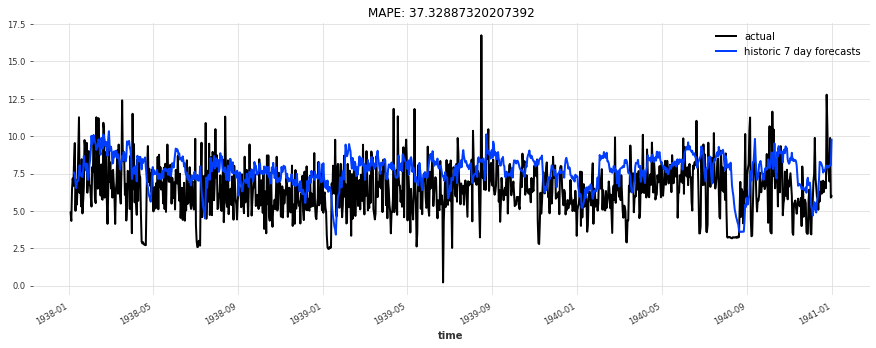

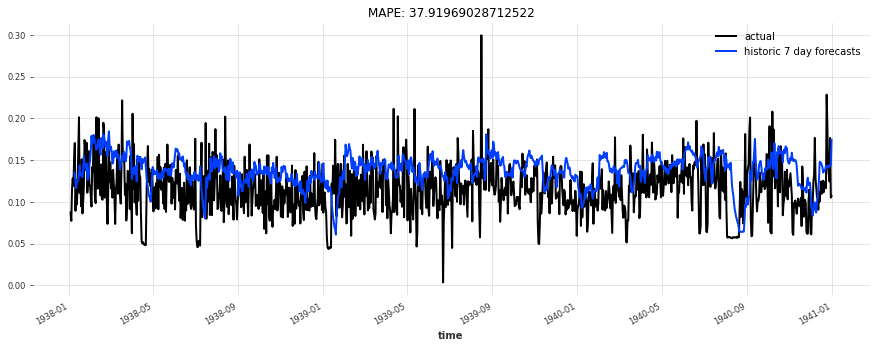

In [ ]:
#Backtest for the prediction of Energy consumption
pred_series_RNN = RNN_model.historical_forecasts(series=series1,
                                          future_covariates=covariates,
                                          start=pd.Timestamp('21470126'),
                                          forecast_horizon=7,
                                          stride=1,
                                          retrain=False,
                                          verbose=True)

#Inverse Scalling for Ploting
Re_pred_I_RNN = scaler.inverse_transform(pred_series_RNN)
Re_series3 = scaler.inverse_transform(series1)
#Display the plot of inverse transformed data
display_forecast(Re_pred_I_RNN, Re_series3, '7 day', start_date=pd.Timestamp('21470126'))

print("Inverse_NBEATS_Interpretable MAPE:", mape(Re_series3, Re_pred_I_RNN))
print("Inverse_NBEATS_Interpretable RMSE:", rmse(Re_series3, Re_pred_I_RNN))
print("Inverse_NBEATS_Interpretable MSE:", mse(Re_series3, Re_pred_I_RNN))

#Scalled Data Ploting
display_forecast(pred_series_RNN, series1, '7 day', start_date=pd.Timestamp('21470126'))
print("NBEATS_Interpretable MAPE:", mape(series1, pred_series_RNN))
print("NBEATS_Interpretable RMSE:", rmse(series1, pred_series_RNN))
print("NBEATS_Interpretable MSE:", mse(series1, pred_series_RNN))

### RNN Model Results Without Covariates

In [ ]:
RNN_model_W = RNNModel(
    model='RNN',
    hidden_dim=20,
    dropout=0,
    batch_size=300,
    n_epochs=100,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='Air_RNN_W',
    log_tensorboard=True,
    random_state=20,
    training_length=24,
    input_chunk_length=12,
    force_reset=True,
    save_checkpoints=True
)

In [ ]:
RNN_model_W.fit(train_transformed, 
             #future_covariates=covariates, 
             val_series=val_transformed, 
             #val_future_covariates=covariates, 
             verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

  0%|          | 0/1089 [00:00<?, ?it/s]

Inverse_NBEATS_Interpretable MAPE: 37.27215986731957
Inverse_NBEATS_Interpretable RMSE: 2.20635338721098
Inverse_NBEATS_Interpretable MSE: 4.867995269257366
NBEATS_Interpretable MAPE: 32.833560700217866
NBEATS_Interpretable RMSE: 0.03526630089718114
NBEATS_Interpretable MSE: 0.0012437119789705197


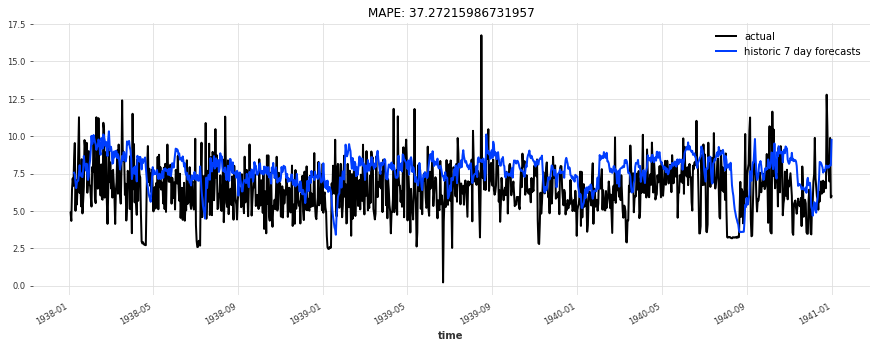

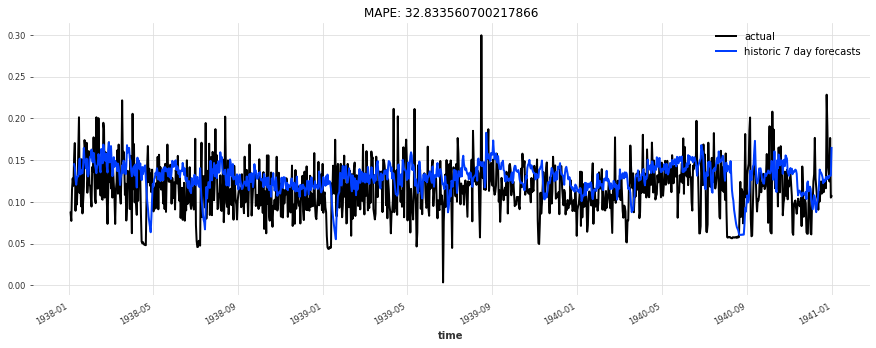

In [ ]:
#Backtest for the prediction of Energy consumption
pred_series_W_RNN = RNN_model_W.historical_forecasts(series=series1,
                                          #future_covariates=covariates,
                                          start=pd.Timestamp('19380102'),
                                          forecast_horizon=7,
                                          stride=1,
                                          retrain=False,
                                          verbose=True)

#Inverse Scalling for Ploting
Re_pred_W_RNN = scaler.inverse_transform(pred_series_RNN)
Re_series4 = scaler.inverse_transform(series1)
#Display the plot of inverse transformed data
display_forecast(Re_pred_W_RNN, Re_series4, '7 day', start_date=pd.Timestamp('19380102'))

print("Inverse_NBEATS_Interpretable MAPE:", mape(Re_series4, Re_pred_W_RNN))
print("Inverse_NBEATS_Interpretable RMSE:", rmse(Re_series4, Re_pred_W_RNN))
print("Inverse_NBEATS_Interpretable MSE:", mse(Re_series4, Re_pred_W_RNN))

#Scalled Data Ploting
display_forecast(pred_series_W_RNN, series1, '7 day', start_date=pd.Timestamp('19380102'))
print("NBEATS_Interpretable MAPE:", mape(series1, pred_series_W_RNN))
print("NBEATS_Interpretable RMSE:", rmse(series1, pred_series_W_RNN))
print("NBEATS_Interpretable MSE:", mse(series1, pred_series_W_RNN))

In [ ]:
def eval_model(RNN_model):
    pred_series = RNN_model_W.predict(n=730)
    plt.figure(figsize=(15,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();

#eval_model(RNN_model)


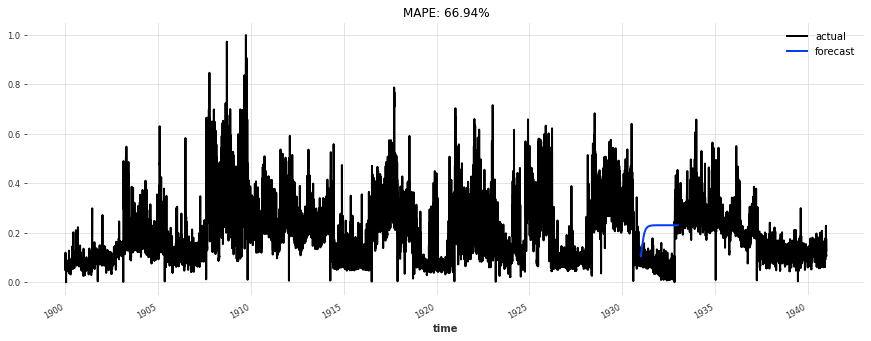

In [ ]:
best_model_RNN = RNN_model_W.load_from_checkpoint(model_name='Air_RNN_W', best=True)
eval_model(RNN_model_W)

# 4. Deep Learning Model LSTM

In [ ]:
LSTM_model = RNNModel(
    model='LSTM',
    hidden_dim=20,
    dropout=0,
    batch_size=300,
    n_epochs=100,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='Air_LSTM',
    log_tensorboard=True,
    random_state=20,
    training_length=24,
    input_chunk_length=12,
    force_reset=True,
    save_checkpoints=True
)

In [ ]:
LSTM_model.fit(train_transformed, 
             future_covariates=covariates, 
             val_series=val_transformed, 
             val_future_covariates=covariates, 
             verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1090 [00:00<?, ?it/s]

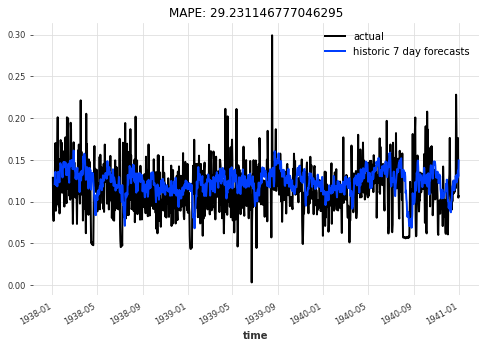

In [ ]:
pred_series_LSTM = RNN_model.historical_forecasts(
    series_transformed,
    start=pd.Timestamp('19380101'), 
    forecast_horizon=7,
    stride=1,
    retrain=False,
    verbose=True
)
display_forecast(pred_series_LSTM, series_transformed, '7 day', start_date=pd.Timestamp('19380101'))

In [ ]:
print("LSTM MAPE:", mape(series_transformed, pred_series_LSTM))
print("LSTM RMSE:", rmse(series_transformed, pred_series_LSTM))
print("LSTM MSE:", mse(series_transformed, pred_series_LSTM))

LSTM MAPE: 29.231146777046295
LSTM RMSE: 0.03208429558153306
LSTM MSE: 0.0010294020229631815


# 5. Deep Learning Model GRU

In [ ]:
GRU_model = RNNModel(
    model='GRU',
    hidden_dim=20,
    dropout=0,
    batch_size=300,
    n_epochs=100,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='Air_GRU',
    log_tensorboard=True,
    random_state=20,
    training_length=24,
    input_chunk_length=12,
    force_reset=True,
    save_checkpoints=True
)

In [ ]:
GRU_model.fit(train_transformed, 
             future_covariates=covariates, 
             val_series=val_transformed, 
             val_future_covariates=covariates, 
             verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1090 [00:00<?, ?it/s]

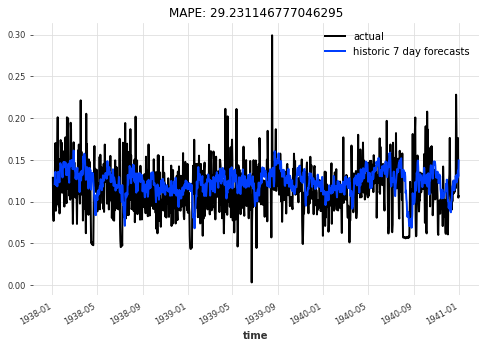

In [ ]:
pred_series_GRU = RNN_model.historical_forecasts(
    series_transformed,
    start=pd.Timestamp('19380101'), 
    forecast_horizon=7,
    stride=1,
    retrain=False,
    verbose=True
)
display_forecast(pred_series_GRU, series_transformed, '7 day', start_date=pd.Timestamp('19380101'))

In [ ]:
print("GRU MAPE:", mape(series_transformed, pred_series_GRU))
print("GRU RMSE:", rmse(series_transformed, pred_series_GRU))
print("GRU MSE:", mse(series_transformed, pred_series_GRU))

GRU MAPE: 29.231146777046295
GRU RMSE: 0.03208429558153306
GRU MSE: 0.0010294020229631815


In [ ]:
def eval_model(RNN_model):
    pred_series = RNNModel.predict(n=1095, future_covariates=covariates)
    plt.figure(figsize=(8,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();
    
eval_model(RNNModel)
print("RNN MAPE:", mape(pred_series, val_transformed))
print("RNN RMSE:", rmse(pred_series, val_transformed))
print("RNN MSE:", mse(pred_series, val_transformed))

TypeError: decorator() missing 1 required positional argument: 'self'

Use the best model obtained over training, according to validation loss:

In [ ]:
best_model = RNNModel.load_from_checkpoint(model_name='Air_RNN', best=True)
eval_model(best_model)

TypeError: decorator() missing 1 required positional argument: 'self'

# Backtesting for LSTM, RNN and GRU


In [ ]:
backtest_series = LSTM_model.historical_forecasts(series_transformed,
                                                future_covariates=covariates,
                                                start=pd.Timestamp('19310101'),
                                                forecast_horizon=6,
                                                retrain=False,
                                                verbose=True)

  0%|          | 0/3648 [00:00<?, ?it/s]

# Backtesting For NBEATS

In [ ]:
backtest_series = model_nbeats_Interpretable.historical_forecasts(series_transformed,
                                                past_covariates=covariates,
                                                start=pd.Timestamp('19310101'),
                                                forecast_horizon=6,
                                                retrain=False,
                                                verbose=True)

  0%|          | 0/3648 [00:00<?, ?it/s]

ValueError: This model has been trained without covariates. No covariates should be provided for prediction.

MAPE: 38.38%
RMSE: 2.59%
MSE: 6.73%


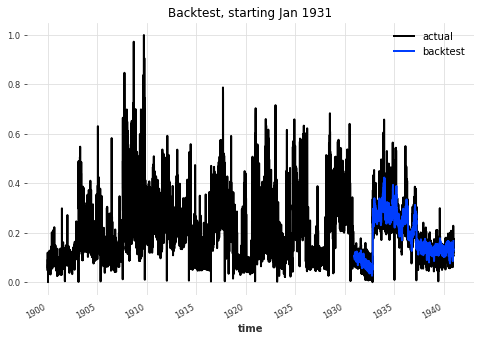

In [ ]:
plt.figure(figsize=(8,5))
series_transformed.plot(label='actual')
backtest_series.plot(label='backtest')
plt.legend()
plt.title('Backtest, starting Jan 1931');
print('MAPE: {:.2f}%'.format(mape(transformer.inverse_transform(series_transformed), 
                                  transformer.inverse_transform(backtest_series))))
print('RMSE: {:.2f}%'.format(rmse(transformer.inverse_transform(series_transformed), 
                                  transformer.inverse_transform(backtest_series))))
print('MSE: {:.2f}%'.format(mse(transformer.inverse_transform(series_transformed), 
                                  transformer.inverse_transform(backtest_series))))

## Monthly sunspots

(True, 7)

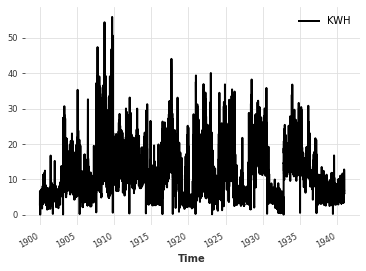

In [ ]:
series_sunspot=series
series_sunspot.plot()
check_seasonality(series_sunspot, max_lag=240)

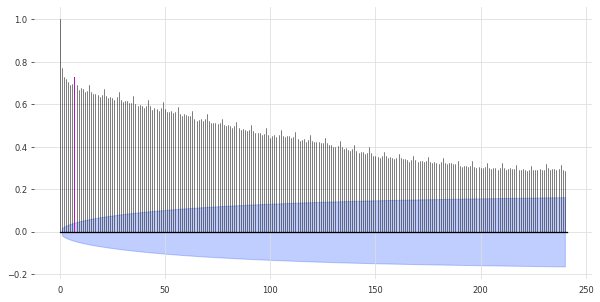

In [ ]:
plot_acf(series_sunspot, 7, max_lag=240) # ~11 years seasonality

In [ ]:
train_sp, val_sp = series_sunspot.split_after(pd.Timestamp('19310101'))

transformer_sunspot = Scaler()
train_sp_transformed = transformer_sunspot.fit_transform(train_sp)
val_sp_transformed = transformer_sunspot.transform(val_sp)
series_sp_transformed = transformer_sunspot.transform(series_sunspot)

In [ ]:
my_model_sun = BlockRNNModel(
    model='GRU',
    input_chunk_length=125,
    output_chunk_length=36,
    hidden_size=10,
    n_rnn_layers=1,
    batch_size=32,
    n_epochs=100,
    dropout=0.1,
    model_name='sun_GRU',
    nr_epochs_val_period=1,
    optimizer_kwargs={'lr': 1e-3},
    log_tensorboard=True,
    random_state=42,
    force_reset=True
)

my_model_sun.fit(train_sp_transformed, val_series=val_sp_transformed, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Compute the backtest predictions with the two models
pred_series_BLOCK_RNN = my_model_sun.historical_forecasts(series_sp_transformed,
                                                start=pd.Timestamp('19380101'), 
                                                forecast_horizon=36,
                                                stride=1,
                                                retrain=False,
                                                last_points_only=True,
                                                verbose=True)

pred_series_ETS = ExponentialSmoothing(seasonal_periods=120).historical_forecasts(series_sp_transformed,
                                                                                  start=pd.Timestamp('19380101'), 
                                                                                  forecast_horizon=36,
                                                                                  stride=1,
                                                                                  retrain=True,
                                                                                  last_points_only=True,
                                                                                  verbose=True)

  0%|          | 0/1061 [00:00<?, ?it/s]

  0%|          | 0/1061 [00:00<?, ?it/s]

RNN MAPE: 20.84574545502391
RNN RMSE: 0.03243127467992829
RNN MSE: 0.0010517875773649577


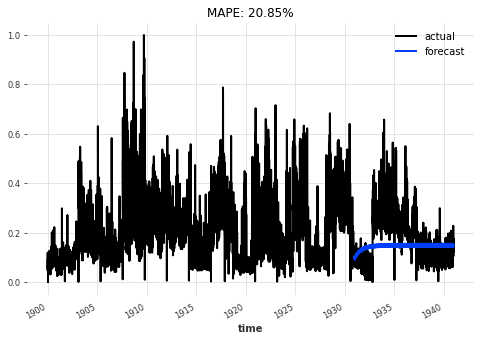

In [ ]:
def eval_model(my_model_sun):
    pred_series = my_model_sun.predict(n=3652)
    plt.figure(figsize=(8,5))
    series_sp_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series_BLOCK_RNN, series_sp_transformed)))
    plt.legend();
    
eval_model(my_model_sun)
print("RNN MAPE:", mape(pred_series_BLOCK_RNN, series_sp_transformed))
print("RNN RMSE:", rmse(pred_series_BLOCK_RNN, series_sp_transformed))
print("RNN MSE:", mse(pred_series_BLOCK_RNN, series_sp_transformed))

RNN MAPE: 98.09435402243686
RNN RMSE: 6.585505351876163
RNN MSE: 43.36888073958959
ETS MAPE: 24.11990563939392
ETS RMSE: 6.585505351876163


NameError: name 'pred_series_ets' is not defined

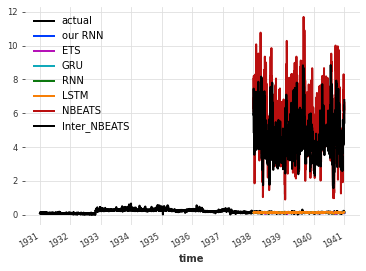

In [ ]:
val_sp_transformed.plot(label='actual')
pred_series_BLOCK_RNN.plot(label='our RNN')
pred_series_ETS.plot(label='ETS')

pred_series_GRU.plot(label='GRU')
pred_series_RNN.plot(label='RNN')
pred_series_LSTM.plot(label='LSTM')
pred_G_NBEATS.plot(label='NBEATS')
pred_series_Inter_NBEATS.plot(label='Inter_NBEATS')

plt.legend();
print("RNN MAPE:", mape(pred_series, val_sp_transformed))
print("RNN RMSE:", rmse(pred_series, val_sp_transformed))
print("RNN MSE:", mse(pred_series, val_sp_transformed))
print("ETS MAPE:", mape(pred_series_ETS, val_sp_transformed))
print("ETS RMSE:", rmse(pred_series, val_sp_transformed))
print("ETS MSE:", mse(pred_series_ets, val_sp_transformed))